[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)

#### based on Fig. 2 from Abade & Albuquerque 2024 (QJRMS)  "_Persistent mixed‐phase states in adiabatic cloud parcels under idealised conditions_"

(work in progress!) # TODO #1656

https://doi.org/10.1002/qj.4775

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import si, in_unit
from PySDM_examples.Abade_and_Albuquerque_2024 import Simulation, Settings

In [20]:
homogenous_commons = {
    'timestep': .5 * si.s,
    'n_sd': 500, #5000, # PAPER: "on the order of 1e6"
    'inp_frac': .5, # PAPER: .1
    'enable_immersion_freezing': True,
    'enable_vapour_deposition_on_ice': True,
}
n_realisations = 3
seeds = range(n_realisations)

simulations = {
    'Bulk': [Simulation(Settings(
        timestep=1 * si.s,
        n_sd=1,
        enable_immersion_freezing=False,
        enable_vapour_deposition_on_ice=False,
    ))],
    'Homogeneous-INAS': [Simulation(Settings(**homogenous_commons, singular=True, seed=seed)) for seed in seeds],
    'Homogeneous-ABIFM': [Simulation(Settings(**homogenous_commons, singular=False, seed=seed)) for seed in seeds],
}

t_max = 6000 * si.s
t_out = 100 * si.s

output = {
    key: {'realisations': [
        val_i.run(nt=int(t_max / val_i.particulator.dt), steps_per_output_interval=int(t_out / val_i.particulator.dt))
        for val_i in val 
    ]}
    for key, val in simulations.items()
}

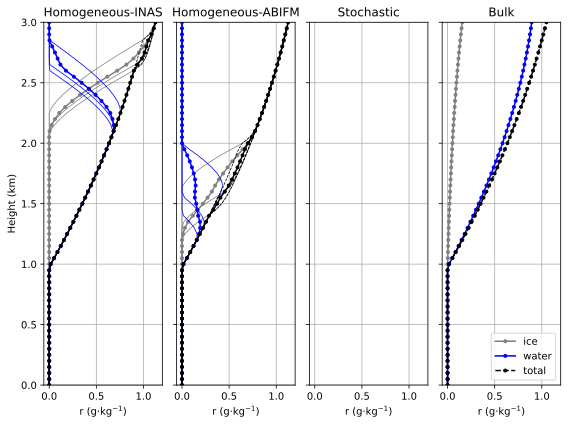

In [26]:
fig, axs = pyplot.subplot_mosaic(
    (('Homogeneous-INAS', 'Homogeneous-ABIFM', 'Stochastic', 'Bulk'),),
    figsize=(8, 6),
    sharex=True,
    sharey=True,
    tight_layout=True,
)

ax = None
for label, ax in reversed(axs.items()):
    ax.set_xlabel(r"r (g$\cdot$kg$^{-1}$)")
    ax.set_title(label)
    ax.set_ylim(0, 3)
    ax.grid()
ax.set_ylabel('Height (km)')

values = {key:{} for key in ('Homogeneous-INAS', 'Homogeneous-ABIFM', 'Bulk')}

colors = {
    'total': 'black',
    'ice': 'gray',
    'water': 'blue',
}

for key in ('Homogeneous-INAS', 'Homogeneous-ABIFM'):
    # compute the total water
    for realisation in output[key]['realisations']:
        realisation['total'] = np.asarray(realisation['water']) + np.asarray(realisation['ice'])

    # compute the means
    output[key]['mean'] = {}
    for name in ('ice', 'water', 'total', 'height'):
        output[key]['mean'][name] = [
            np.mean([realisation[name][level] for realisation in output[key]['realisations']]) 
            for level in range(len(output[key]['realisations'][0][name]))
        ]

# Homogeneous
for key in ('Homogeneous-INAS', 'Homogeneous-ABIFM'):
    for name in ('ice', 'water', 'total'):
        for realisation in output[key]['realisations']:
            axs[key].plot(
                in_unit(np.asarray(realisation[name]), si.g / si.kg),
                in_unit(np.asarray(realisation['height']), si.km),
                linestyle='--' if name == 'total' else '-',
                color=colors[name],
                linewidth=.75,
            )
        mean = output[key]['mean']
        axs[key].plot(
            in_unit(np.asarray(mean[name]), si.g / si.kg),
            in_unit(np.asarray(mean['height']), si.km),
            label=name,
            marker='.',
            color=colors[name],
        )

# Bulk
assert len(simulations['Bulk']) == 1
simulation = simulations['Bulk'][0]
bulk_output = output['Bulk']['realisations'][0]
liquid_fraction = simulation.particulator.formulae.bulk_phase_partitioning.liquid_fraction(np.asarray(bulk_output['T']))
total_water_mixing_ratio = np.asarray(bulk_output['water'])
for name in ('ice', 'water', 'total'):
    values['Bulk'][name] = {
        'total': total_water_mixing_ratio,
        'ice': (1 - liquid_fraction) * total_water_mixing_ratio,
        'water': liquid_fraction * total_water_mixing_ratio
    }[name]
    
    axs['Bulk'].plot(
        in_unit(values['Bulk'][name], si.g / si.kg),
        in_unit(np.asarray(bulk_output['height']), si.km),
        label=name,
        marker='.',
        color=colors[name],
        linestyle='--' if name == 'total' else '-'
    )
axs['Bulk'].legend()

show_plot('fig_2.pdf')